In [8]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from transformers import AutoModel, AutoTokenizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, log_loss

In [9]:

# ------------------------ Device Setup ------------------------
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.xpu.is_available():
    device = torch.device("xpu")
else:
    device = torch.device("cpu")
print("Using device:", device)



Using device: cuda


In [10]:
# ------------------------ Data Loading & Preprocessing ------------------------
df = pd.read_csv("constraint_Hindi_Train - Sheet1.csv")

In [11]:
def clean_text(text):
    # Remove URLs and punctuation, then extra spaces
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\.\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning to dataset
df["Post"] = df["Post"].apply(clean_text)



In [12]:
df.head()

,Unique ID,Post,Labels Set
0,1,मर दश क हनद बहत नरल ह कछ त पकक रम भकत ह और कछ ...,"hate,offensive"
1,2,सरकर हमश स कसन क कमई क बढन क लए नईनई सकम लत रह...,non-hostile
2,3,सशत न ज बजनस डल 9 जन क क थ व डल दपश क सशत क हत...,non-hostile
3,4,prabhav218 सल जएनय छप कमन लग हनदओ क यह कहत ह क...,"defamation,offensive"
4,5,unlock4guidelines अनलक4 क लए गइडलइनस जर 7 सतबर...,non-hostile


In [13]:

# Check for missing values and dataset shape
num_rows, num_columns = df.shape
print(f"\nNumber of Rows: {num_rows}")
print(f"Number of Columns: {num_columns}")
print("\nMissing Values:")
print(df.isnull().sum())



Number of Rows: 5728
Number of Columns: 3

Missing Values:
Unique ID     0
Post          0
Labels Set    0
dtype: int64


In [14]:

# Process labels
df['Labels Set'] = df['Labels Set'].str.split(',')
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(df['Labels Set'])

label_counts = Counter(label for labels_list in df['Labels Set'] for label in labels_list)
print("\nLabel Distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count}")



Label Distribution:
hate: 792
offensive: 742
non-hostile: 3050
defamation: 564
fake: 1144


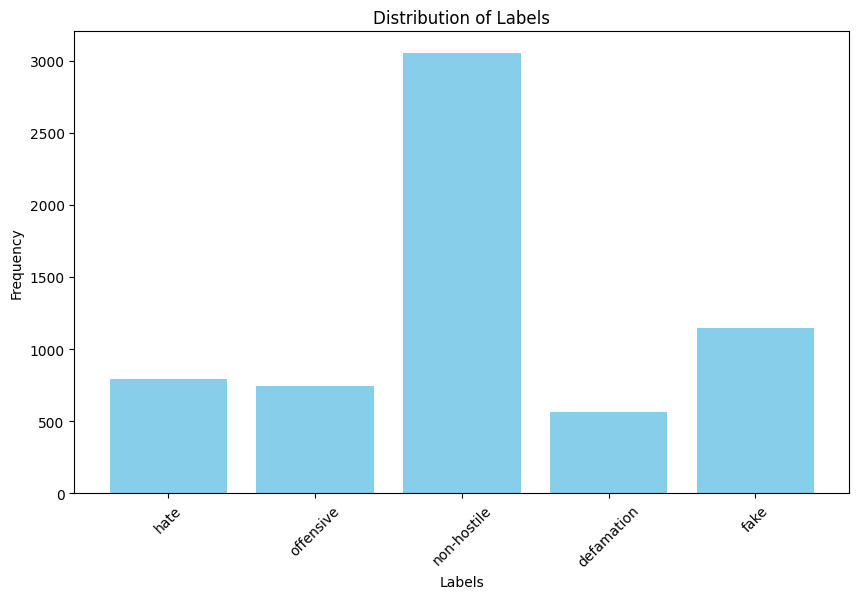

In [15]:
# Visualize label distribution
plt.figure(figsize=(10, 6))
plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Labels')
plt.xticks(rotation=45)
plt.show()


Single-label Records: 5247
Multi-label Records: 481


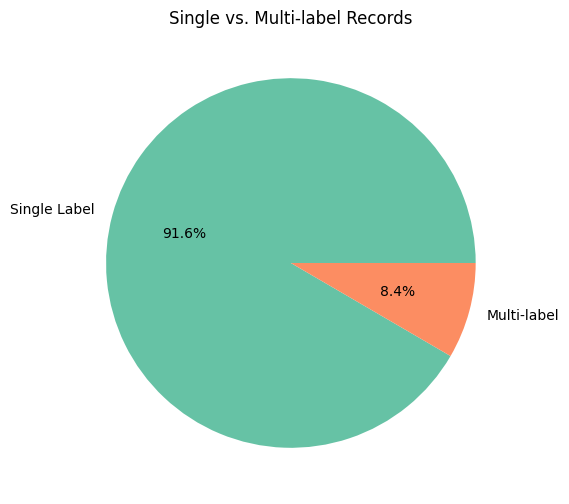

In [ ]:
# Single vs. Multi-label count
df['Num Labels'] = df['Labels Set'].apply(len)
single_label = df[df['Num Labels'] == 1].shape[0]
multi_label = df[df['Num Labels'] > 1].shape[0]
print(f"\nSingle-label Records: {single_label}")
print(f"Multi-label Records: {multi_label}")

plt.figure(figsize=(6, 6))
plt.pie([single_label, multi_label],
        labels=['Single Label', 'Multi-label'],
        autopct='%1.1f%%',
        colors=['#66c2a5', '#fc8d62
plt.title('Single vs. Multi-label Records')
plt.show()

In [17]:

# ------------------------ Tokenization ------------------------
tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")
indic_bert = AutoModel.from_pretrained("ai4bharat/indic-bert")
indic_bert.to(device)

max_length = 128
df['Tokens'] = df['Post'].apply(lambda text: tokenizer(text, 
                                                       padding='max_length', 
                                                       truncation=True, 
                                                       max_length=max_length, 
                                                       return_tensors="pt")['input_ids'].squeeze())

In [18]:

# ------------------------ Train-Test Split & Tensor Conversion ------------------------
X_train, X_test, y_train, y_test = train_test_split(df['Tokens'].tolist(), labels, test_size=0.2, random_state=42)
X_train_tensor = torch.stack(X_train).to(device)
X_test_tensor = torch.stack(X_test).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

train_dataset = data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = data.TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 16
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
# ------------------------ Define the Hybrid Model ------------------------
class HybridModel(nn.Module):
    def __init__(self, bert_model, num_classes):
        super(HybridModel, self).__init__()
        self.bert = bert_model
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=256, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids):
        with torch.no_grad():
            bert_output = self.bert(input_ids).last_hidden_state
        conv1_out = self.relu(self.conv1(bert_output.permute(0, 2, 1)))
        conv2_out = self.relu(self.conv2(conv1_out))
        pooled = torch.mean(conv2_out, dim=2)
        output = self.sigmoid(self.fc(pooled))
        return output

num_classes = y_train.shape[1]
model = HybridModel(indic_bert, num_classes)
model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [20]:
# ------------------------ Training & Evaluation Functions ------------------------
def train_epoch(model, loader):
    model.train()
    epoch_loss = 0.0
    all_targets = []
    all_preds = []
    
    for inputs, targets in tqdm(loader, desc="Training", leave=False):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        preds = (outputs.detach().cpu().numpy() > 0.5).astype(int)
        all_preds.append(preds)
        all_targets.append(targets.detach().cpu().numpy())
        
    avg_loss = epoch_loss / len(loader)
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    # Calculate metrics (accuracy, precision, recall, F1)
    accuracy = np.mean(all_preds == all_targets)
    precision = precision_score(all_targets, all_preds, average='micro', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='micro', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='micro', zero_division=0)
    
    return avg_loss, accuracy, precision, recall, f1

def evaluate(model, loader):
    model.eval()
    epoch_loss = 0.0
    all_targets = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, targets in loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_loss += loss.item()
            preds = (outputs.cpu().numpy() > 0.5).astype(int)
            all_preds.append(preds)
            all_targets.append(targets.cpu().numpy())
            
    avg_loss = epoch_loss / len(loader)
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    accuracy = np.mean(all_preds == all_targets)
    precision = precision_score(all_targets, all_preds, average='micro', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='micro', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='micro', zero_division=0)
    
    return avg_loss, accuracy, precision, recall, f1


In [21]:
# ------------------------ Training Loop with Early Stopping ------------------------
target_accuracy = 0.95
improvement_threshold = 0.001
patience = 40
best_model_path = "nlp_model/best_model.pth"
os.makedirs(os.path.dirname(best_model_path), exist_ok=True)

train_losses, train_accuracies, train_precisions, train_recalls, train_f1s = [], [], [], [], []
best_accuracy = 0.0
epochs_without_improve = 0
epoch = 0

while True:
    epoch += 1
    avg_loss, acc, prec, rec, f1 = train_epoch(model, train_loader)
    train_losses.append(avg_loss)
    train_accuracies.append(acc)
    train_precisions.append(prec)
    train_recalls.append(rec)
    train_f1s.append(f1)
    
    print(f"Epoch {epoch}: Loss={avg_loss:.4f} Acc={acc:.4f} Prec={prec:.4f} Rec={rec:.4f} F1={f1:.4f}")
    
    # Check for improvement
    if acc > best_accuracy + improvement_threshold:
        best_accuracy = acc
        epochs_without_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"--> New best model saved with accuracy: {best_accuracy:.4f}")
    else:
        epochs_without_improve += 1
        
    # Stop conditions
    if acc >= target_accuracy:
        print(f"Target accuracy of {target_accuracy} reached at epoch {epoch}.")
        break
    if epochs_without_improve >= patience:
        print(f"Saturation reached: No significant improvement for {patience} epochs.")
        torch.save(model.state_dict(), best_model_path)
        break

Training:   0%|          | 0/287 [00:00<?, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch 1: Loss=0.4609 Acc=0.8019 Prec=0.5728 Rec=0.3827 F1=0.4588
--> New best model saved with accuracy: 0.8019


Epoch 2: Loss=0.4192 Acc=0.8318 Prec=0.6922 Rec=0.4208 F1=0.5234
--> New best model saved with accuracy: 0.8318


Epoch 3: Loss=0.3946 Acc=0.8416 Prec=0.7513 Rec=0.4163 F1=0.5357
--> New best model saved with accuracy: 0.8416


Epoch 4: Loss=0.3782 Acc=0.8467 Prec=0.7729 Rec=0.4270 F1=0.5501
--> New best model saved with accuracy: 0.8467


Epoch 5: Loss=0.3674 Acc=0.8481 Prec=0.7760 Rec=0.4326 F1=0.5555
--> New best model saved with accuracy: 0.8481


Epoch 6: Loss=0.3569 Acc=0.8514 Prec=0.7875 Rec=0.4423 F1=0.5665
--> New best model saved with accuracy: 0.8514


Epoch 7: Loss=0.3484 Acc=0.8533 Prec=0.7996 Rec=0.4421 F1=0.5694
--> New best model saved with accuracy: 0.8533


Epoch 8: Loss=0.3416 Acc=0.8545 Prec=0.7953 Rec=0.4537 F1=0.5778
--> New best model saved with accuracy: 0.8545


Epoch 9: Loss=0.3358 Acc=0.8579 Prec=0.8096 Rec=0.4608 F1=0.5873
--> New best model saved with accuracy: 0.8579


Epoch 10: Loss=0.3303 Acc=0.8577 Prec=0.8027 Rec=0.4662 F1=0.5898


Epoch 11: Loss=0.3259 Acc=0.8621 Prec=0.8196 Rec=0.4763 F1=0.6025
--> New best model saved with accuracy: 0.8621


Epoch 12: Loss=0.3218 Acc=0.8611 Prec=0.8093 Rec=0.4801 F1=0.6027


Epoch 13: Loss=0.3188 Acc=0.8625 Prec=0.8166 Rec=0.4819 F1=0.6061


Epoch 14: Loss=0.3156 Acc=0.8639 Prec=0.8129 Rec=0.4934 F1=0.6141
--> New best model saved with accuracy: 0.8639


Epoch 15: Loss=0.3119 Acc=0.8650 Prec=0.8216 Rec=0.4918 F1=0.6153
--> New best model saved with accuracy: 0.8650


Epoch 16: Loss=0.3089 Acc=0.8662 Prec=0.8171 Rec=0.5030 F1=0.6227
--> New best model saved with accuracy: 0.8662


Epoch 17: Loss=0.3071 Acc=0.8677 Prec=0.8201 Rec=0.5088 F1=0.6280
--> New best model saved with accuracy: 0.8677


Epoch 18: Loss=0.3046 Acc=0.8688 Prec=0.8220 Rec=0.5133 F1=0.6320
--> New best model saved with accuracy: 0.8688


Epoch 19: Loss=0.3024 Acc=0.8667 Prec=0.8101 Rec=0.5125 F1=0.6278


Epoch 20: Loss=0.2988 Acc=0.8711 Prec=0.8272 Rec=0.5219 F1=0.6400
--> New best model saved with accuracy: 0.8711


Epoch 21: Loss=0.2972 Acc=0.8704 Prec=0.8203 Rec=0.5247 F1=0.6400


Epoch 22: Loss=0.2950 Acc=0.8716 Prec=0.8176 Rec=0.5340 F1=0.6461


Epoch 23: Loss=0.2927 Acc=0.8727 Prec=0.8261 Rec=0.5318 F1=0.6471
--> New best model saved with accuracy: 0.8727


Epoch 24: Loss=0.2901 Acc=0.8732 Prec=0.8185 Rec=0.5426 F1=0.6526


Epoch 25: Loss=0.2878 Acc=0.8753 Prec=0.8260 Rec=0.5467 F1=0.6580
--> New best model saved with accuracy: 0.8753


Epoch 26: Loss=0.2857 Acc=0.8764 Prec=0.8288 Rec=0.5507 F1=0.6617
--> New best model saved with accuracy: 0.8764


Epoch 27: Loss=0.2836 Acc=0.8763 Prec=0.8241 Rec=0.5545 F1=0.6629


Epoch 28: Loss=0.2809 Acc=0.8784 Prec=0.8289 Rec=0.5619 F1=0.6697
--> New best model saved with accuracy: 0.8784


Epoch 29: Loss=0.2793 Acc=0.8790 Prec=0.8318 Rec=0.5626 F1=0.6713


Epoch 30: Loss=0.2771 Acc=0.8794 Prec=0.8293 Rec=0.5672 F1=0.6737
--> New best model saved with accuracy: 0.8794


Epoch 31: Loss=0.2761 Acc=0.8797 Prec=0.8257 Rec=0.5728 F1=0.6764


Epoch 32: Loss=0.2733 Acc=0.8822 Prec=0.8327 Rec=0.5800 F1=0.6837
--> New best model saved with accuracy: 0.8822


Epoch 33: Loss=0.2719 Acc=0.8806 Prec=0.8265 Rec=0.5770 F1=0.6796


Epoch 34: Loss=0.2684 Acc=0.8823 Prec=0.8326 Rec=0.5805 F1=0.6841


Epoch 35: Loss=0.2680 Acc=0.8838 Prec=0.8342 Rec=0.5873 F1=0.6893
--> New best model saved with accuracy: 0.8838


Epoch 36: Loss=0.2630 Acc=0.8842 Prec=0.8324 Rec=0.5915 F1=0.6915


Epoch 37: Loss=0.2627 Acc=0.8850 Prec=0.8344 Rec=0.5941 F1=0.6940
--> New best model saved with accuracy: 0.8850


Epoch 38: Loss=0.2591 Acc=0.8871 Prec=0.8369 Rec=0.6032 F1=0.7011
--> New best model saved with accuracy: 0.8871


Epoch 39: Loss=0.2580 Acc=0.8862 Prec=0.8337 Rec=0.6014 F1=0.6988


Epoch 40: Loss=0.2576 Acc=0.8873 Prec=0.8354 Rec=0.6058 F1=0.7023


Epoch 41: Loss=0.2537 Acc=0.8887 Prec=0.8363 Rec=0.6126 F1=0.7072
--> New best model saved with accuracy: 0.8887


Epoch 42: Loss=0.2518 Acc=0.8884 Prec=0.8327 Rec=0.6150 F1=0.7075


Epoch 43: Loss=0.2483 Acc=0.8913 Prec=0.8422 Rec=0.6209 F1=0.7148
--> New best model saved with accuracy: 0.8913


Epoch 44: Loss=0.2467 Acc=0.8919 Prec=0.8437 Rec=0.6227 F1=0.7166


Epoch 45: Loss=0.2452 Acc=0.8923 Prec=0.8419 Rec=0.6269 F1=0.7187
--> New best model saved with accuracy: 0.8923


Epoch 46: Loss=0.2420 Acc=0.8933 Prec=0.8445 Rec=0.6299 F1=0.7216
--> New best model saved with accuracy: 0.8933


Epoch 47: Loss=0.2387 Acc=0.8943 Prec=0.8478 Rec=0.6317 F1=0.7240


Epoch 48: Loss=0.2385 Acc=0.8965 Prec=0.8455 Rec=0.6466 F1=0.7328
--> New best model saved with accuracy: 0.8965


Epoch 49: Loss=0.2354 Acc=0.8961 Prec=0.8499 Rec=0.6396 F1=0.7299


Epoch 50: Loss=0.2358 Acc=0.8954 Prec=0.8399 Rec=0.6468 F1=0.7308


Epoch 51: Loss=0.2298 Acc=0.8990 Prec=0.8494 Rec=0.6561 F1=0.7404
--> New best model saved with accuracy: 0.8990


Epoch 52: Loss=0.2276 Acc=0.9005 Prec=0.8569 Rec=0.6563 F1=0.7433
--> New best model saved with accuracy: 0.9005


Epoch 53: Loss=0.2262 Acc=0.9008 Prec=0.8550 Rec=0.6601 F1=0.7450


Epoch 54: Loss=0.2257 Acc=0.9023 Prec=0.8580 Rec=0.6647 F1=0.7491
--> New best model saved with accuracy: 0.9023


Epoch 55: Loss=0.2228 Acc=0.9027 Prec=0.8602 Rec=0.6645 F1=0.7498


Epoch 56: Loss=0.2196 Acc=0.9031 Prec=0.8551 Rec=0.6724 F1=0.7528


Epoch 57: Loss=0.2159 Acc=0.9052 Prec=0.8604 Rec=0.6778 F1=0.7583
--> New best model saved with accuracy: 0.9052


Epoch 58: Loss=0.2157 Acc=0.9058 Prec=0.8624 Rec=0.6792 F1=0.7599


Epoch 59: Loss=0.2114 Acc=0.9088 Prec=0.8663 Rec=0.6909 F1=0.7688
--> New best model saved with accuracy: 0.9088


Epoch 60: Loss=0.2089 Acc=0.9088 Prec=0.8655 Rec=0.6921 F1=0.7691


Epoch 61: Loss=0.2087 Acc=0.9096 Prec=0.8616 Rec=0.7007 F1=0.7728


Epoch 62: Loss=0.2056 Acc=0.9109 Prec=0.8729 Rec=0.6951 F1=0.7739
--> New best model saved with accuracy: 0.9109


Epoch 63: Loss=0.2030 Acc=0.9096 Prec=0.8651 Rec=0.6965 F1=0.7717


Epoch 64: Loss=0.1998 Acc=0.9137 Prec=0.8729 Rec=0.7100 F1=0.7831
--> New best model saved with accuracy: 0.9137


Epoch 65: Loss=0.1994 Acc=0.9134 Prec=0.8698 Rec=0.7122 F1=0.7832


Epoch 66: Loss=0.1949 Acc=0.9160 Prec=0.8794 Rec=0.7152 F1=0.7889
--> New best model saved with accuracy: 0.9160


Epoch 67: Loss=0.1955 Acc=0.9154 Prec=0.8755 Rec=0.7164 F1=0.7880


Epoch 68: Loss=0.1907 Acc=0.9189 Prec=0.8830 Rec=0.7267 F1=0.7973
--> New best model saved with accuracy: 0.9189


Epoch 69: Loss=0.1879 Acc=0.9190 Prec=0.8814 Rec=0.7289 F1=0.7980


Epoch 70: Loss=0.1871 Acc=0.9182 Prec=0.8767 Rec=0.7299 F1=0.7966


Epoch 71: Loss=0.1847 Acc=0.9216 Prec=0.8855 Rec=0.7383 F1=0.8052
--> New best model saved with accuracy: 0.9216


Epoch 72: Loss=0.1805 Acc=0.9230 Prec=0.8878 Rec=0.7428 F1=0.8089
--> New best model saved with accuracy: 0.9230


Epoch 73: Loss=0.1791 Acc=0.9228 Prec=0.8833 Rec=0.7468 F1=0.8094


Epoch 74: Loss=0.1784 Acc=0.9240 Prec=0.8860 Rec=0.7500 F1=0.8124
--> New best model saved with accuracy: 0.9240


Epoch 75: Loss=0.1761 Acc=0.9261 Prec=0.8913 Rec=0.7554 F1=0.8177
--> New best model saved with accuracy: 0.9261


Epoch 76: Loss=0.1747 Acc=0.9261 Prec=0.8904 Rec=0.7562 F1=0.8178


Epoch 77: Loss=0.1704 Acc=0.9284 Prec=0.8990 Rec=0.7591 F1=0.8232
--> New best model saved with accuracy: 0.9284


Epoch 78: Loss=0.1669 Acc=0.9296 Prec=0.8965 Rec=0.7681 F1=0.8273
--> New best model saved with accuracy: 0.9296


Epoch 79: Loss=0.1661 Acc=0.9300 Prec=0.8976 Rec=0.7689 F1=0.8283


Epoch 80: Loss=0.1629 Acc=0.9318 Prec=0.9013 Rec=0.7741 F1=0.8329
--> New best model saved with accuracy: 0.9318


Epoch 81: Loss=0.1605 Acc=0.9326 Prec=0.8988 Rec=0.7806 F1=0.8356


Epoch 82: Loss=0.1598 Acc=0.9307 Prec=0.8973 Rec=0.7729 F1=0.8304


Epoch 83: Loss=0.1577 Acc=0.9337 Prec=0.8992 Rec=0.7862 F1=0.8389
--> New best model saved with accuracy: 0.9337


Epoch 84: Loss=0.1551 Acc=0.9352 Prec=0.9038 Rec=0.7888 F1=0.8424
--> New best model saved with accuracy: 0.9352


Epoch 85: Loss=0.1536 Acc=0.9350 Prec=0.8995 Rec=0.7924 F1=0.8426


Epoch 86: Loss=0.1506 Acc=0.9368 Prec=0.9059 Rec=0.7946 F1=0.8466
--> New best model saved with accuracy: 0.9368


Epoch 87: Loss=0.1474 Acc=0.9398 Prec=0.9140 Rec=0.8011 F1=0.8538
--> New best model saved with accuracy: 0.9398


Epoch 88: Loss=0.1471 Acc=0.9391 Prec=0.9100 Rec=0.8019 F1=0.8525


Epoch 89: Loss=0.1451 Acc=0.9402 Prec=0.9101 Rec=0.8071 F1=0.8555


Epoch 90: Loss=0.1411 Acc=0.9430 Prec=0.9182 Rec=0.8126 F1=0.8622
--> New best model saved with accuracy: 0.9430


Epoch 91: Loss=0.1404 Acc=0.9423 Prec=0.9145 Rec=0.8128 F1=0.8607


Epoch 92: Loss=0.1388 Acc=0.9437 Prec=0.9168 Rec=0.8176 F1=0.8644


Epoch 93: Loss=0.1342 Acc=0.9459 Prec=0.9205 Rec=0.8248 F1=0.8700
--> New best model saved with accuracy: 0.9459


Epoch 94: Loss=0.1340 Acc=0.9458 Prec=0.9183 Rec=0.8266 F1=0.8700


Epoch 95: Loss=0.1308 Acc=0.9481 Prec=0.9274 Rec=0.8286 F1=0.8752
--> New best model saved with accuracy: 0.9481


Epoch 96: Loss=0.1287 Acc=0.9475 Prec=0.9234 Rec=0.8298 F1=0.8741


Epoch 97: Loss=0.1292 Acc=0.9472 Prec=0.9209 Rec=0.8309 F1=0.8736


Epoch 98: Loss=0.1267 Acc=0.9490 Prec=0.9264 Rec=0.8339 F1=0.8777


Epoch 99: Loss=0.1220 Acc=0.9506 Prec=0.9281 Rec=0.8401 F1=0.8819
--> New best model saved with accuracy: 0.9506
Target accuracy of 0.95 reached at epoch 99.


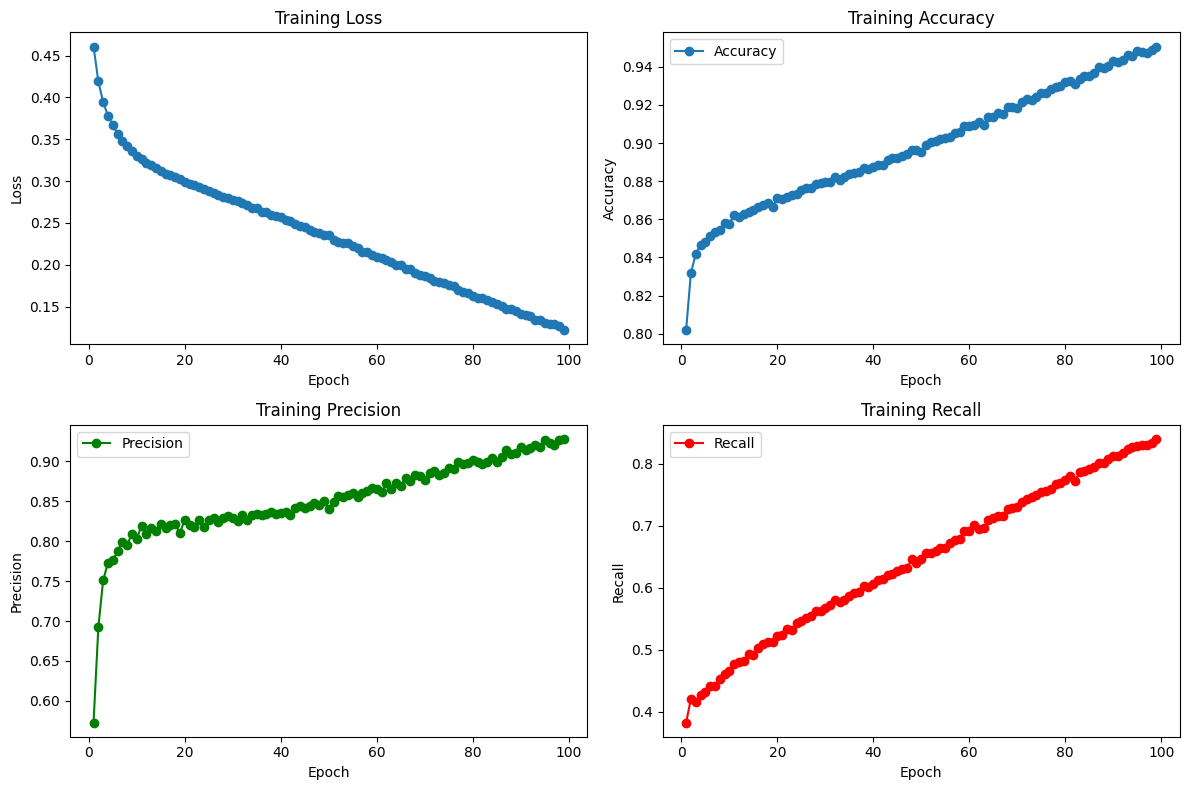

In [22]:
# ------------------------ Plot Metrics ------------------------
epochs = range(1, epoch + 1)
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, marker='o', label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, train_precisions, marker='o', label='Precision', color='green')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Training Precision')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, train_recalls, marker='o', label='Recall', color='red')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Training Recall')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
# ------------------------ Load Best Model & Evaluate on Test Set ------------------------
model.load_state_dict(torch.load("./nlp_model/best_model.pth"))
test_loss, test_acc, test_prec, test_rec, test_f1 = evaluate(model, test_loader)
print("\nTest Set Evaluation:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")


Test Set Evaluation:
Test Loss: 0.4771
Test Accuracy: 0.8468
Test Precision: 0.6838
Test Recall: 0.5680
Test F1 Score: 0.6206


In [24]:
import joblib

# Save MultiLabelBinarizer
joblib.dump(mlb, "mlb.pkl")
print("MultiLabelBinarizer saved!")

MultiLabelBinarizer saved!
